In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torchvision

from model import Discriminator, Generator
from preprocess import get_images, get_mask
from torchsummary import summary
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
n_epochs = 15
alpha = 0.02
learning_rate = 0.001
batch_size = 32

In [5]:
train_loader, test_loader = get_images(batch_size)
image_size = (32, 32)
square_size = 16
binary_mask = get_mask(image_size, square_size)
# reshape binary mask to add batch_size dimension
binary_mask = binary_mask.unsqueeze(0)
binary_mask = binary_mask.expand(batch_size, -1, -1)
binary_mask = binary_mask.to(device)

print(binary_mask.shape)

100%|██████████| 170498071/170498071 [00:11<00:00, 15014464.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
torch.Size([32, 32, 32])


In [6]:
generator = Generator().to(device)
summary(generator, [(3, 32, 32), (32, 32)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─GatedConv: 2-1                    [-1, 32, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 32, 32]          3,232
|    |    └─Conv2d: 3-2                  [-1, 32, 32, 32]          3,232
|    |    └─Sigmoid: 3-3                 [-1, 32, 32, 32]          --
|    |    └─LeakyReLU: 3-4               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-5               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-6               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-7               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─GatedConv: 2-1                    [-1, 32, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 32, 32]          3,232
|    |    └─Conv2d: 3-2                  [-1, 32, 32, 32]          3,232
|    |    └─Sigmoid: 3-3                 [-1, 32, 32, 32]          --
|    |    └─LeakyReLU: 3-4               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-5               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-6               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |    └─LeakyReLU: 3-7               [-1, 32, 32, 32]          --
|    └─GatedConv: 2                      []                        --
|    |   

In [8]:
discriminator = Discriminator().to(device)
summary(discriminator, [(3, 32, 32), (32, 32)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─SpectralNormConv: 2-1             [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          6,464
|    |    └─LeakyReLU: 3-2               [-1, 64, 16, 16]          --
|    └─SpectralNormConv: 2-2             [-1, 128, 8, 8]           --
|    |    └─Conv2d: 3-3                  [-1, 128, 8, 8]           204,928
|    |    └─LeakyReLU: 3-4               [-1, 128, 8, 8]           --
|    └─SpectralNormConv: 2-3             [-1, 256, 4, 4]           --
|    |    └─Conv2d: 3-5                  [-1, 256, 4, 4]           819,456
|    |    └─LeakyReLU: 3-6               [-1, 256, 4, 4]           --
|    └─SpectralNormConv: 2-4             [-1, 256, 2, 2]           --
|    |    └─Conv2d: 3-7                  [-1, 256, 2, 2]           1,638,656
|    |    └─LeakyReLU: 3-8               [-1, 256, 2, 2]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─SpectralNormConv: 2-1             [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          6,464
|    |    └─LeakyReLU: 3-2               [-1, 64, 16, 16]          --
|    └─SpectralNormConv: 2-2             [-1, 128, 8, 8]           --
|    |    └─Conv2d: 3-3                  [-1, 128, 8, 8]           204,928
|    |    └─LeakyReLU: 3-4               [-1, 128, 8, 8]           --
|    └─SpectralNormConv: 2-3             [-1, 256, 4, 4]           --
|    |    └─Conv2d: 3-5                  [-1, 256, 4, 4]           819,456
|    |    └─LeakyReLU: 3-6               [-1, 256, 4, 4]           --
|    └─SpectralNormConv: 2-4             [-1, 256, 2, 2]           --
|    |    └─Conv2d: 3-7                  [-1, 256, 2, 2]           1,638,656
|    |    └─LeakyReLU: 3-8               [-1, 256, 2, 2]         

In [51]:
learning_rate_gen = 0.0001
learning_rate_dis = 0.0004

opt_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate_gen)
opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_dis)

938

In [52]:
for epoch in range(n_epochs):
    #Training
    train_loss = 0
    loss = 0
    generator.train()
    discriminator.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)
        # clear the gradients of all optimized variables
        opt_generator.zero_grad()
        opt_discriminator.zero_grad()
        # model forward
        x_fake, x_coarse, x_refinement = generator(data, binary_mask)
        x_all = torch.cat([x_fake, data], dim=0)
        masks_double = torch.cat([binary_mask, binary_mask], dim=0)
        x_hat_all = discriminator(x_all, binary_mask)
        # compute the discriminator loss
        loss_dis = discriminator.loss_function(x_hat_all[:batch_size], x_hat_all[batch_size:])
        x_hat_dis = discriminator(x_fake, binary_mask)
        
        loss_gen = generator.loss_function(x_hat_dis)
        loss_recon = generator.combined_rec_loss_function(data, x_coarse, x_refinement, binary_mask)
        loss_gen += loss_recon

        # backward/update generator
        loss_gen.backward()
        opt_generator.step()

        # backward/update discriminator
        opt_discriminator.zero_grad()
        loss_dis.backward()
        opt_discriminator.step()

        # update running training loss
        train_loss += loss_gen + loss_dis
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Epoch: 0 	Training Loss: 0.007339
Epoch: 1 	Training Loss: 0.005001
Epoch: 2 	Training Loss: 0.004884
Epoch: 3 	Training Loss: 0.004549
Epoch: 4 	Training Loss: 0.004860
Epoch: 5 	Training Loss: 0.004531
Epoch: 6 	Training Loss: 0.004273
Epoch: 7 	Training Loss: 0.004132
Epoch: 8 	Training Loss: 0.004007
Epoch: 9 	Training Loss: 0.004142
Epoch: 10 	Training Loss: 0.004063
Epoch: 11 	Training Loss: 0.003941
Epoch: 12 	Training Loss: 0.004024
Epoch: 13 	Training Loss: 0.004662
Epoch: 14 	Training Loss: 0.004384


In [53]:
#Testing
test_loss = count = 0
loss = 0
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)
        # model forward
        x_fake, x_coarse, x_refinement = generator(data, binary_mask)
        x_all = torch.cat([x_fake, data], dim=0)
        masks_double = torch.cat([binary_mask, binary_mask], dim=0)
        x_hat_all = discriminator(x_all, binary_mask)
        # compute the discriminator loss
        loss_dis = discriminator.loss_function(x_hat_all[:batch_size], x_hat_all[batch_size:])
        x_hat_dis = discriminator(x_fake, binary_mask)
        # compute the loss
        loss_dis = discriminator.loss_function(x_hat_all[:batch_size], x_hat_all[batch_size:])
        x_hat_dis = discriminator(x_fake, binary_mask)
        loss_gen = generator.loss_function(x_hat_dis)
        loss_recon = generator.combined_rec_loss_function(data, x_coarse, x_refinement, binary_mask)
        loss_gen = loss_gen + loss_recon
        # update running training loss
        test_loss += (loss_gen + loss_dis)

    test_loss = test_loss / count
    print('Test Loss: {:.6f}'.format(test_loss))

625

In [54]:
val_loss = count = 0
torch.cuda.empty_cache()
inpaint.eval()
input = None
output = None

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)
        x_hat = inpaint(data, binary_mask)
        loss = inpaint.loss_function(x_hat, data, binary_mask, alpha)
        val_loss += loss
        count += 1

        input = data
        output = x_hat
    
val_loss = val_loss / count
print(f'Validation loss: {val_loss:.4f}')


Validation loss: 0.0039


In [55]:
# B x C x H x W
input = input[:5]
output = output[:5]

# B x H x W x C
input = input.permute(0, 2, 3, 1)
output = output.permute(0, 2, 3, 1)

input = input.cpu()
output = output.cpu()

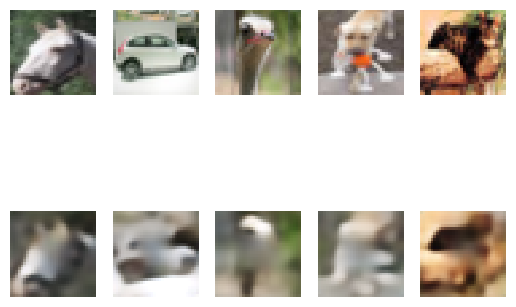

In [56]:
f, axarr = plt.subplots(2,5)
axarr[0, 0].axis("off")
axarr[0, 0].imshow(input[0], interpolation='nearest')
axarr[0, 1].axis("off")
axarr[0, 1].imshow(input[1], interpolation='nearest')
axarr[0, 2].axis("off")
axarr[0, 2].imshow(input[2], interpolation='nearest')
axarr[0, 3].axis("off")
axarr[0, 3].imshow(input[3], interpolation='nearest')
axarr[0, 4].axis("off")
axarr[0, 4].imshow(input[4], interpolation='nearest')

axarr[1, 0].axis("off")
axarr[1, 0].imshow(output[0], interpolation='nearest')
axarr[1, 1].axis("off")
axarr[1, 1].imshow(output[1], interpolation='nearest')
axarr[1, 2].axis("off")
axarr[1, 2].imshow(output[2], interpolation='nearest')
axarr[1, 3].axis("off")
axarr[1, 3].imshow(output[3], interpolation='nearest')
axarr[1, 4].axis("off")
axarr[1, 4].imshow(output[4], interpolation='nearest')